# Objectif de ce notebook
1. Evaluer la qualité des datasets générés par 0_generate_dataset.ipynb
2. Explorer les données des datasets

# Importer toutes les libraries nécessaires avec la cellule suivante

In [ ]:
import numpy as np
import pandas as pd
import random
import string

# ****Modélisation et prédiction****
## Objectifs
- Déterminer le modèle le plus adéquate pour prédire la note d'un item
- Tester plusieurs modèles, les évaluer et garder le meilleur modèle

## 1. Modèles de regression
## 1.1. RandomForestRegressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Génération des données
df = pd.read_csv("../data/item_dataset.csv")

# 2. Sélection des variables numériques
features = ["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight"]
target = "note"

X = df[features]
y = df[target]

# 3. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Prédictions
y_pred = model.predict(X_test)

# 6. Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.3f}")

RMSE : 8.75
R² : 0.368


## 1.2. GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Générer les données
df = pd.read_csv("../data/item_dataset.csv")

# Features utilisées pour l'entraînement
features = ["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight"]
target = "note"

X = df[features]
y = df[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

# Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"GradientBoostingRegressor → RMSE : {rmse:.2f}")
print(f"GradientBoostingRegressor → R² : {r2:.3f}")

GradientBoostingRegressor → RMSE : 8.78
GradientBoostingRegressor → R² : 0.448


### 1.3. Bilan des modèles de regression
On remarque que pour les deux premiers modèles, le RMSE semble correcte mais l'indicateur R2 semble indiquer que les  modèles ne prédisent pas correctement le comportement souhaité

On va donc vérifier l'importance des features au sein du dataset

In [22]:
importances = model.feature_importances_
for feat, imp in zip(features, importances):
    print(f"{feat} : {imp:.3f}")


nb_stats : 0.461
nb_perfect_lines : 0.279
nb_high_ratio : 0.054
total_weight : 0.158
exo_weight : 0.018
over_weight : 0.031


On remarque que le nb_perfect_lines joue un grand rôle dans l'évaluation ce qui est normal
Il faut donc trouver une alternative pour enrichir les features ou simplifier la prédiction

Remarque : essayons de classifier nos résultats afin de faire de la classification

## 2. Modèle par classification
## 2.1. RandomForestClassifier

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00        17
  jet mauvais       0.47      0.43      0.45       591
    jet moyen       0.48      0.49      0.49       981
  jet parfait       0.67      0.09      0.16        22
 très bon jet       0.68      0.71      0.69      1389

     accuracy                           0.57      3000
    macro avg       0.46      0.34      0.36      3000
 weighted avg       0.57      0.57      0.57      3000

Matrice de confusion :
[[  0   0   4   0  13]
 [  1 256 219   0 115]
 [  1 178 479   0 323]
 [  1   0   1   2  18]
 [  6 113 285   1 984]]


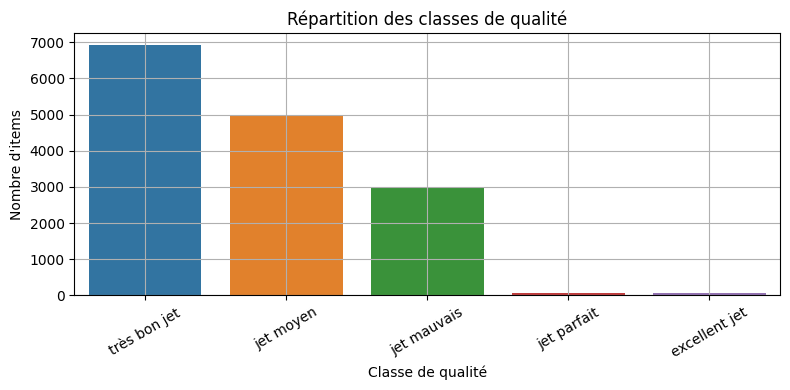

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


On remarque qu'il y a beaucoup trop d'item avec un très bon jet.

On va rééquilibrer le modèle pour qu'il se foacalise davantage sur les classes minoritaires

## 2.2. RandomForestClassifier Balanced

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00        17
  jet mauvais       0.45      0.43      0.44       591
    jet moyen       0.49      0.49      0.49       981
  jet parfait       0.50      0.05      0.08        22
 très bon jet       0.68      0.70      0.69      1389

     accuracy                           0.57      3000
    macro avg       0.42      0.33      0.34      3000
 weighted avg       0.57      0.57      0.57      3000

Matrice de confusion :
[[  0   0   4   0  13]
 [  0 256 219   0 116]
 [  1 186 479   0 315]
 [  1   0   2   1  18]
 [  5 123 283   1 977]]


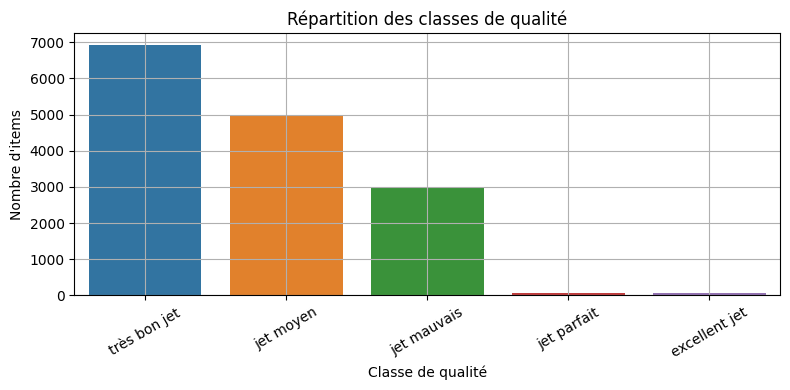

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.3. GradientBoostingClassifier

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00        17
  jet mauvais       0.60      0.39      0.47       591
    jet moyen       0.51      0.53      0.52       981
  jet parfait       0.71      0.23      0.34        22
 très bon jet       0.69      0.79      0.74      1389

     accuracy                           0.62      3000
    macro avg       0.50      0.39      0.42      3000
 weighted avg       0.61      0.62      0.61      3000

Matrice de confusion :
[[   0    0    1    0   16]
 [   0  228  257    0  106]
 [   0  108  524    0  349]
 [   0    0    0    5   17]
 [   2   45  237    2 1103]]


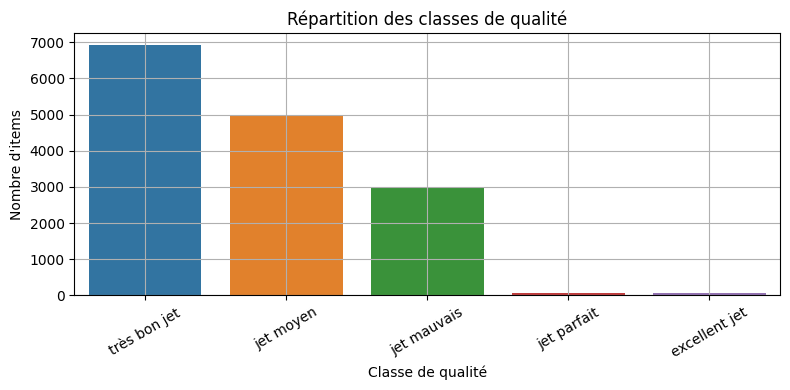

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


On va simplifier la classification

## 2.4. GradientBoostingClassifier simplified classes

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 90:
        return "très bon jet"
    elif note > 75:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Ajout des features dérivées manquantes
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight",
             "exo_weight", "over_weight", "perfect_ratio",
             "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, random_state=42)
clf.fit(df_train, y_train)

# Prédiction
y_pred = clf.predict(df_test)

# Évaluation
print("Classification Report (simplifié) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Classification Report (simplifié) :
              precision    recall  f1-score   support

 jet mauvais       0.56      0.42      0.48       733
   jet moyen       0.67      0.80      0.73      1692
 jet parfait       0.39      0.32      0.35        22
très bon jet       0.60      0.45      0.51       553

    accuracy                           0.64      3000
   macro avg       0.55      0.50      0.52      3000
weighted avg       0.63      0.64      0.62      3000

Matrice de confusion :
[[ 307  395    0   31]
 [ 214 1349    3  126]
 [   0    3    7   12]
 [  24  272    8  249]]
